# Initialization

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
from matplotlib import pyplot as plt
import matplotlib
import boto3

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_work_dir_path = os.path.split(os.path.split(os.path.split(os.path.dirname(os.path.realpath("__file__")))[0])[0])[0]
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = '/'.join([prefix, 'workdir3'])
s3_saves_dir_path = '/'.join([s3_work_dir_path , 'model_saves'])
s3_data_dir_path = '/'.join([s3_work_dir_path , 'data'])
s3_data_ver_dir_path = '/'.join([s3_data_dir_path,'100K_V4'])

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig

In [10]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
perplexity = 5

# Load

## dataset

In [6]:
X = from_s3_npy(s3_client, bucket_name, '/'.join([s3_data_ver_dir_path, 'X_test_set.npy']))

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/X_test_set.npy


In [7]:
wl_grid = from_s3_npy(s3_client, bucket_name, '/'.join([s3_data_ver_dir_path, 'wl_100K_V4.npy']))

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/wl_100K_V4.npy


In [8]:
gs = from_s3_pkl(s3_client, bucket_name, '/'.join([s3_data_ver_dir_path,'gs_test_V4.pkl']))

loading from uri: s3://tau-astro/almogh/workdir3/data/100K_V4/gs_test_V4.pkl


In [11]:
snr = gs.snMedian.tolist()

## RF

In [56]:
D_RF = from_s3_npy(s3_client, bucket_name, 'almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/dist_mat_hat_test_set.npy')

loading from uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/dist_mat_hat_test_set.npy


In [13]:
RF_weird_scores = np.mean(D_RF, axis=1)

In [14]:
RF_sne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', verbose=1, random_state=seed).fit_transform(D_RF)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.174s...
[t-SNE] Computed neighbors for 10000 samples in 1.634s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.046980
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.571976
[t-SNE] KL divergence after 1000 iterations: 3.323006


### Plotting TSNE

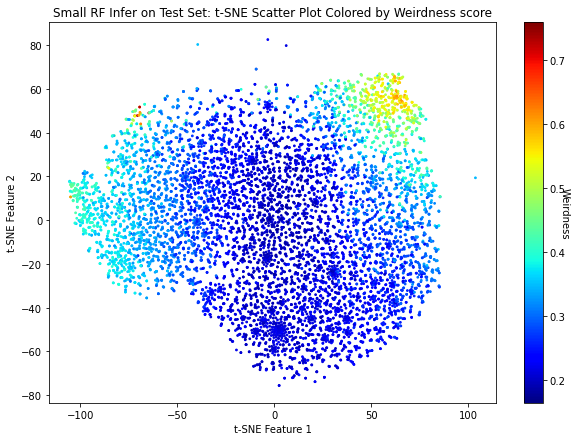

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/tsne_colored_by_weirdness-test_set.png


True

In [51]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(RF_sne[:,0], RF_sne[:,1], s=3, c=RF_weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r'Small RF Infer on Test Set: t-SNE Scatter Plot Colored by Weirdness score')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/tsne_colored_by_weirdness-test_set.png')

### Scores Histogram

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/weirdness_scores_histogram-test_set.png


True

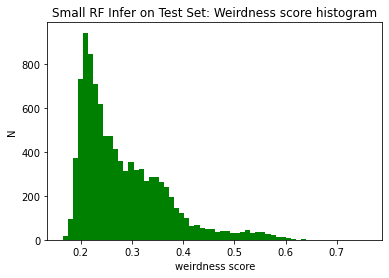

In [54]:
fig = plt.figure()
tmp = plt.hist(RF_weird_scores, bins=60, color="g")
plt.title("Small RF Infer on Test Set: Weirdness score histogram")
plt.ylabel("N")
plt.xlabel("weirdness score")

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/weirdness_scores_histogram-test_set.png')

### Distances Histogram

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/distances_histogram-test_set.png


True

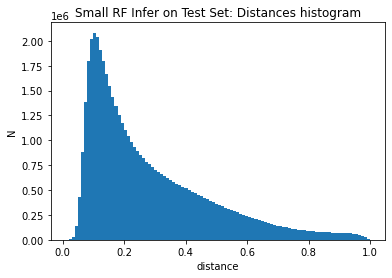

In [57]:
distances = D_RF[np.tril_indices(D_RF.shape[0], -1)]

fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("Small RF Infer on Test Set: Distances histogram")
plt.ylabel("N")
plt.xlabel("distance")

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/RF/simple___2022_05_07___18_57_07___100K_V4_training_set/distances_histogram-test_set.png')

In [58]:
del D_RF, distances

## NN

In [76]:
Z_NN = from_s3_npy(s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/dist_mat_hat_test_set.npy')

loading from uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/dist_mat_hat_test_set.npy


In [77]:
# Loading Z - the upper triangular part of the distance matrices - and recreating the distances matrix
N = int((-1+np.sqrt(1+8*len(Z_NN)))/2)
D_NN = np.zeros(shape=(N,N))
D_NN[np.triu_indices(N)] = Z_NN
D_NN = D_NN.T
D_NN[np.triu_indices(N)] = Z_NN

In [78]:
del Z_NN

In [22]:
# calculating weirdness scores and t-SNE
NN_weird_scores = np.mean(D_NN, axis=1)
NN_sne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', verbose=1, random_state=seed).fit_transform(D_NN)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.208s...
[t-SNE] Computed neighbors for 10000 samples in 5.226s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.057954
[t-SNE] KL divergence after 250 iterations with early exaggeration: 151.691406
[t-SNE] KL divergence after 1000 iterations: 4.346707


### Plotting TSNE

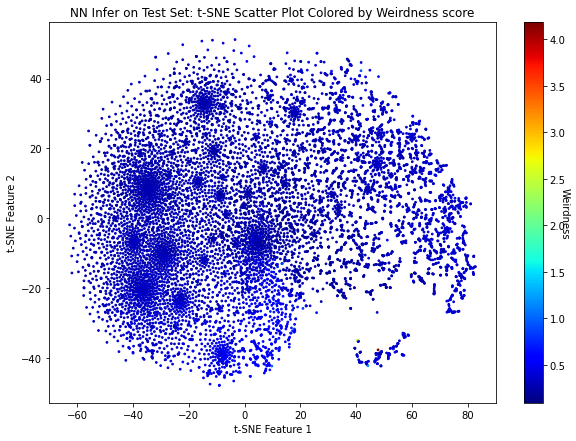

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/tsne_colored_by_weirdness-test_set.png


True

In [53]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(NN_sne[:,0], NN_sne[:,1], s=3, c=NN_weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r'NN Infer on Test Set: t-SNE Scatter Plot Colored by Weirdness score')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/tsne_colored_by_weirdness-test_set.png')

### Scores Histogram

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-test_set.png


True

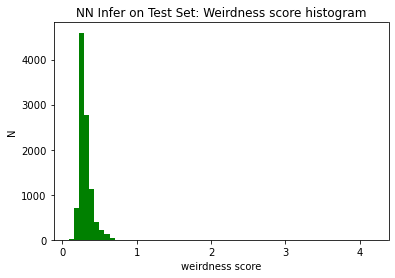

In [55]:
fig = plt.figure()
tmp = plt.hist(NN_weird_scores, bins=60, color="g")
plt.title("NN Infer on Test Set: Weirdness score histogram")
plt.ylabel("N")
plt.xlabel("weirdness score")

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/weirdness_scores_histogram-test_set.png')

### Distances Histogram

In [79]:
distances = D_NN[np.tril_indices(D_NN.shape[0], -1)]

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-test_set.png


True

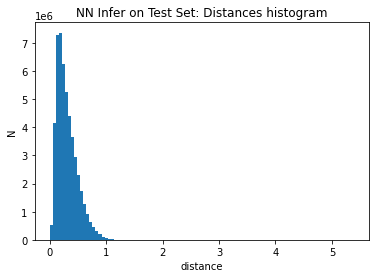

In [62]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("NN Infer on Test Set: Distances histogram")
plt.ylabel("N")
plt.xlabel("distance")

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-log-test_set.png


True

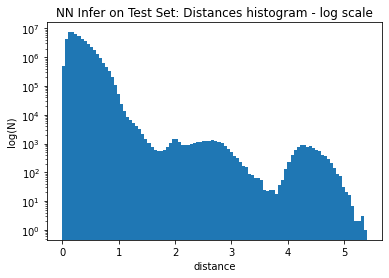

In [80]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("NN Infer on Test Set: Distances histogram - log scale")
plt.ylabel("log(N)")
plt.xlabel("distance")
plt.yscale('log')

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainV4___2022_05_09___07_29_04___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-log-test_set.png')

In [81]:
del D_NN, distances

## NN + AWGN

In [69]:
Z_NN_AWGN = from_s3_npy(s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/dist_mat_hat_test_set.npy')

loading from uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/dist_mat_hat_test_set.npy


In [70]:
# Loading Z - the upper triangular part of the distance matrices - and recreating the distances matrix
N = int((-1+np.sqrt(1+8*len(Z_NN_AWGN)))/2)
D_NN_AWGN = np.zeros(shape=(N,N))
D_NN_AWGN[np.triu_indices(N)] = Z_NN_AWGN
D_NN_AWGN = D_NN_AWGN.T
D_NN_AWGN[np.triu_indices(N)] = Z_NN_AWGN

In [71]:
del Z_NN_AWGN

In [36]:
# calculating weirdness scores and t-SNE
NN_AWGN_weird_scores = np.mean(D_NN_AWGN, axis=1)
NN_AWGN_sne = TSNE(n_components=2, perplexity=perplexity, metric='precomputed', verbose=1, random_state=seed).fit_transform(D_NN_AWGN)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.220s...
[t-SNE] Computed neighbors for 10000 samples in 5.989s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.043447
[t-SNE] KL divergence after 250 iterations with early exaggeration: 144.774185
[t-SNE] KL divergence after 1000 iterations: 4.094184


### Plotting TSNE

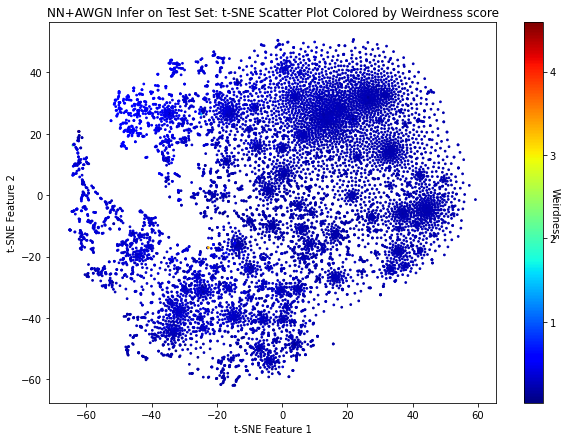

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/tsne_colored_by_weirdness-test_set.png


True

In [50]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(NN_AWGN_sne[:,0], NN_AWGN_sne[:,1], s=3, c=NN_AWGN_weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r'NN+AWGN Infer on Test Set: t-SNE Scatter Plot Colored by Weirdness score')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/tsne_colored_by_weirdness-test_set.png')

### Plotting Distances

In [72]:
distances = D_NN_AWGN[np.tril_indices(D_NN_AWGN.shape[0], -1)]

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-test_set.png


True

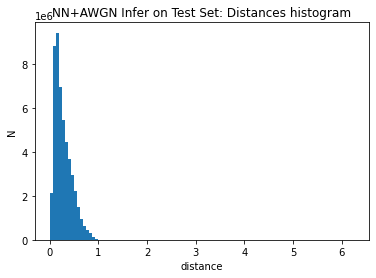

In [67]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("NN+AWGN Infer on Test Set: Distances histogram")
plt.ylabel("N")
plt.xlabel("distance")

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-test_set.png')

saving to uri: s3://tau-astro/almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-log-test_set.png


True

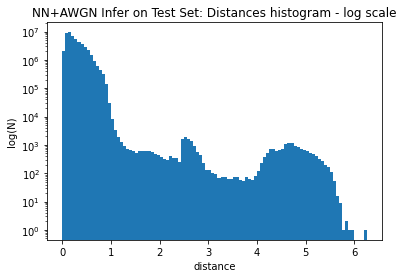

In [74]:
fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("NN+AWGN Infer on Test Set: Distances histogram - log scale")
plt.ylabel("log(N)")
plt.xlabel("distance")
plt.yscale('log')

to_s3_fig(fig, s3_client, bucket_name, 'almogh/workdir3/model_saves/NN/100K_V4/LongTrainDenoiseV4___2022_05_09___07_28_03___Kernels_31_Filters_64_32_16_8_4_Hiddens_512_128_tanh/distances_histogram-log-test_set.png')

In [75]:
del D_NN_AWGN, distances

# Plot

## Definitions

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
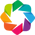

In [38]:
# Imports
from datetime import datetime
import traceback
import holoviews as hv
from holoviews import opts
from holoviews.streams import Selection1D
from bokeh.models import HoverTool
from scipy import stats
import panel as pn
from holoviews.plotting.links import DataLink
hv.extension('bokeh')

In [39]:
# creading the dataframe for RF
RF_df = pd.DataFrame()
RF_df['feature_1'] = RF_sne[:,0]
RF_df['feature_2'] = RF_sne[:,1]
RF_df['score'] = RF_weird_scores
RF_df['snr'] = snr
RF_df['index'] = np.arange(len(RF_df))

# creading the dataframe for NN
NN_df = pd.DataFrame()
NN_df['feature_1'] = NN_sne[:,0]
NN_df['feature_2'] = NN_sne[:,1]
NN_df['score'] = NN_weird_scores
NN_df['snr'] = snr
NN_df['index'] = np.arange(len(NN_df))

# creading the dataframe for NN+AWGN
NN_AWGN_df = pd.DataFrame()
NN_AWGN_df['feature_1'] = NN_AWGN_sne[:,0]
NN_AWGN_df['feature_2'] = NN_AWGN_sne[:,1]
NN_AWGN_df['score'] = NN_AWGN_weird_scores
NN_AWGN_df['snr'] = snr
NN_AWGN_df['index'] = np.arange(len(NN_AWGN_df))

# full dataframe
full_df = pd.DataFrame()
full_df['RF_feature_1'] = RF_sne[:,0]
full_df['RF_feature_2'] = RF_sne[:,1]
full_df['NN_feature_1'] = NN_sne[:,0]
full_df['NN_feature_2'] = NN_sne[:,1]
full_df['NN_AWGN_feature_1'] = NN_AWGN_sne[:,0]
full_df['NN_AWGN_feature_2'] = NN_AWGN_sne[:,1]
full_df['score'] = RF_weird_scores
full_df['snr'] = snr
full_df['index'] = np.arange(len(RF_df))

In [44]:
def points_dmap_callable_inner(src, color_src):
    points = hv.Points(full_df, kdims=[src+'_feature_1', src+'_feature_2']).opts(color=color_src, cmap='jet').opts(tools=['tap','box_select','lasso_select']).opts(selection_line_color='black', selection_alpha=0.7, nonselection_alpha=0.1).opts(framewise=True, width=700, height=500, colorbar=True)
    return points

def points_dmap_callable(color_src):
    """
    The callable function for the points DynamicMap.
    """
    RF_points = points_dmap_callable_inner('RF', color_src)
    NN_points = points_dmap_callable_inner('NN', color_src)
    NN_AWGN_points = points_dmap_callable_inner('NN_AWGN', color_src)
    NN_dlink = DataLink(RF_points, NN_points)
    NN_AWGN_dlink = DataLink(RF_points, NN_AWGN_points)
    points_layout = (RF_points+NN_points+NN_AWGN_points)
    points_layout = (RF_points+NN_AWGN_points)
    return points_layout

def spectra_dmap_callable(index):
    """
    The callable function for the spectra DynamicMap.
    """
    with open(os.path.join(local_work_dir_path,'debug.txt'),'w') as f:
        f.write('in spectra_dmap_callable - '+datetime.now().strftime("%d/%m/%Y %H:%M:%S")+'\n')
        try:
            w = wl_grid
            if len(index)==0:
                f.write('len==0\n')
                # No Selection
                x = np.zeros(shape=wl_grid.shape)
                label = 'No Selection'
                x_max_err = x
                x_min_err = x
            else:
                f.write('len!=0\n')
                x = np.nanmean(X[index], axis=0)
                #x_valid = ~np.isnan(x)
                #x = x[x_valid]
                #w = w[x_valid]
                if len(index)==1:
                    f.write('len==1\n')
                    # a single point - plotting the outlier feature importance
                    label = 'index=%s, snr=%f, RF score=%f, NN score=%f, NN+AWGN score=%f' % (index[0], snr[index[0]], RF_weird_scores[index[0]], NN_weird_scores[index[0]], NN_AWGN_weird_scores[index[0]])
                    x_max_err = np.zeros_like(x)
                    x_min_err = np.zeros_like(x)
                else:
                    f.write('len>1\n')
                    # Multiple points - plotting the cluster feature importance
                    label = '%d points selected - plotting the average' % len(index)
                    x_max_err = np.nanmax(X[index], axis=0)-x
                    x_min_err = x-np.nanmin(X[index], axis=0)
                
            # decimating max and min by 2 (for some reason, spread is not showing from over ~5000 points)
            f.write('x_max_err type = {0}\n'.format(str(type(x_max_err))))
            f.write('x_max_err shape = {0}\n'.format(str(x_max_err.shape)))
            D = 2
            w_spread = w[::D].reshape(-1)
            x_spread = x[::D].reshape(-1)
            x_max_err = x_max_err[::D].reshape(-1)
            x_min_err = x_min_err[::D].reshape(-1)
            #x_spread = np.mean(x.reshape(-1,D),axis=1).reshape(-1)
            #x_max_err = np.max(x_max_err.reshape(-1,D),axis=1).reshape(-1)
            #x_max_err = np.zeros_like(x_spread)
            #x_min_err = np.max(x_min_err.reshape(-1,D),axis=1).reshape(-1)
            #x_min_err = np.zeros_like(x_spread)
            assert len(w_spread)==len(x_spread)==len(x_max_err)==len(x_min_err), 'length must be equal! shapes are {0}, {1}, {2}, {3}.'.format(w_spread.shape, x_spread.shape,x_max_err.shape, x_min_err.shape)

            #flux = hv.Curve((w,x), kdims=['w'],vdims=['flux']).opts(color='black')
            flux = hv.Curve((w,x), kdims=['w'],vdims=['flux']).opts(color='black').opts(norm=dict(framewise=True)) * hv.Spread((w_spread,x_spread,x_min_err,x_max_err), kdims=['w'],vdims=['flux', 'yerrneg', 'yerrpos']).opts(fill_alpha=0.5, line_alpha=0).opts(norm=dict(framewise=True))
            #flux = hv.Curve((w,x), kdims=['w'],vdims=['flux']).opts(color='black') * hv.Curve((w_spread,x_spread), kdims=['w'],vdims=['flux']).opts(color='red')
            #flux = hv.Spread((w,x,x_min_err,x_max_err), kdims=['w'],vdims=['y', 'yerrneg', 'yerrpos'])
            #np.save(r'C:\Users\ahershko\OneDrive - Qualcomm\Documents\Thesis\git\w.npy', w)
            #np.save(r'C:\Users\ahershko\OneDrive - Qualcomm\Documents\Thesis\git\x.npy', x)
            #np.save(r'C:\Users\ahershko\OneDrive - Qualcomm\Documents\Thesis\git\x_max_err.npy', x_max_err)
            #np.save(r'C:\Users\ahershko\OneDrive - Qualcomm\Documents\Thesis\git\x_min_err.npy', x_min_err)
        
        except Exception as e:
            f.write('exception!\n')
            f.write(str(e)+'\n')
            tb = traceback.format_exc()
            f.write(tb)
            
        flux = flux.opts(tools=['hover']).relabel(label).opts(width=800, height=300, show_grid=True)

        #f.write('flux is an object of type: {0}\n'.format(str(type(flux))))
        #f.write('exiting...\n')
    
    return flux

## Interactive plot

In [45]:
color_src = 'score'
RF_points = points_dmap_callable_inner('RF', color_src)
NN_points = points_dmap_callable_inner('NN', color_src)
NN_AWGN_points = points_dmap_callable_inner('NN_AWGN', color_src)

NN_dlink = DataLink(RF_points, NN_points)
NN_AWGN_dlink = DataLink(RF_points, NN_AWGN_points)

selection = Selection1D(source=RF_points) # creating a selection from the points
spectra_dmap = hv.DynamicMap(spectra_dmap_callable, kdims=[], streams=[selection])
spectra_dmap.opts(norm=dict(framewise=True))

# Building the layout full layout
layout = (RF_points+NN_points+NN_AWGN_points+spectra_dmap).opts(merge_tools=False)
layout.cols(1)

:Layout
   .Points.I     :Points   [RF_feature_1,RF_feature_2]   (NN_feature_1,NN_feature_2,NN_AWGN_feature_1,NN_AWGN_feature_2,score,snr,index)
   .Points.II    :Points   [NN_feature_1,NN_feature_2]   (RF_feature_1,RF_feature_2,NN_AWGN_feature_1,NN_AWGN_feature_2,score,snr,index)
   .Points.III   :Points   [NN_AWGN_feature_1,NN_AWGN_feature_2]   (RF_feature_1,RF_feature_2,NN_feature_1,NN_feature_2,score,snr,index)
   .DynamicMap.I :DynamicMap   []
      :Overlay
         .Curve.I  :Curve   [w]   (flux)
         .Spread.I :Spread   [w]   (flux,yerrneg,yerrpos)